# **Práctica 3 : Análisis de Señales ECG**



*   Antonia Yepes Quintero - 1036960061
*   Isabella Bedoya Orozco - 1001013873



In [64]:
import numpy as np
import scipy.io as sio
from scipy.signal import find_peaks
import scipy.stats as st
from scipy.stats import kstest, norm, levene, ttest_ind, mannwhitneyu
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
data = sio.loadmat ('/content/drive/MyDrive/Colab Notebooks/signals.mat')
print(data.keys())
ecg_filtrada = data['ECG_filtered'].flatten()
ecg_cruda = data['ECG_asRecording'].flatten()
print(ecg_filtrada.shape)

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'ECG_asRecording', 'ECG_filtered', 'EMG_filtered1', 'EMG_filtered2', 'EMG_asRecording1', 'EMG_asRecording2'])
(30720,)


La función RMS permite calcular el valor cuadrático medio de una señal y se define en forma discreta con N número de muestras como:

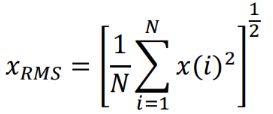


Creación de la función RMS:

In [66]:
def calcular_rms(signal):
  N = len(signal)
  valor_rms = np.sqrt(np.sum(signal**2)/N)
  return valor_rms

Se crea el vector de tiempo para ambas señales:

In [67]:
Fs = 1024  # Frecuencia de muestreo en Hz
T = 1 / Fs
muestras = (ecg_cruda.size)
t = np.arange(0,muestras*T, T)
print(t)

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 2.99970703e+01
 2.99980469e+01 2.99990234e+01]


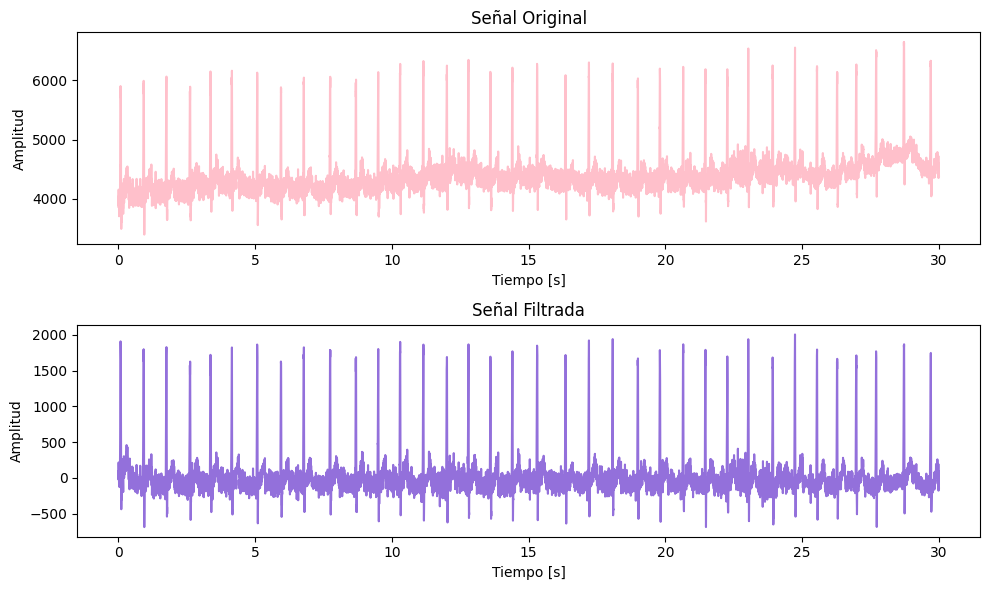

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.subplot(2, 1, 1)
plt.plot(t,ecg_cruda, color = 'pink')
plt.title('Señal Original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

plt.subplot(2, 1, 2)
plt.plot(t,ecg_filtrada, color = 'mediumpurple')
plt.title('Señal Filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.tight_layout()
plt.show()


**Observaciones:**
La señal original presenta un alto nivel de ruido, con oscilaciones adicionales a las respectivas del latido del corazón. Además, de un desplazamiento estando centrada alrededor de los 4000.
En cambio, la señal filtrada muestra una notable reduccion del ruido y esta centrada en 0, lo que indica que el filtro aplicado a corregido el desplazamiento (offset). Los picos de los latidos del corazón permanecen en la señal filtrada, lo que sugiere que el filtro ha eliminado componentes no deseadas sin comprometer los datos relacionados al ECG. Es probable que el filtro utilizado haya sido un pasa-bajo o basa-banda, el cual puede preservar las frecuencias relevantes para el ECG y reducir tanto el ruido de alta frecuencia como el desplazamiento de base.


Graficación de un ciclo cardiaco de la señal original:

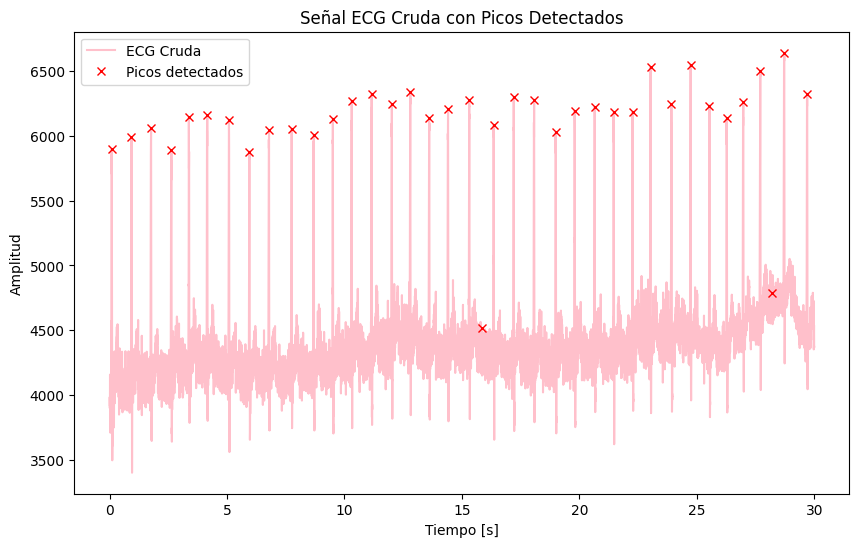

In [69]:
peaks, _ = find_peaks(ecg_cruda, distance=Fs/2, height=0)  # Ajustar los parámetros si es necesario
plt.figure(figsize=(10, 6))
plt.plot(t, ecg_cruda, label='ECG Cruda', color='pink')
plt.plot(t[peaks], ecg_cruda[peaks], 'rx', label='Picos detectados')
plt.title('Señal ECG Cruda con Picos Detectados')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

Text(0, 0.5, 'Amplitud')

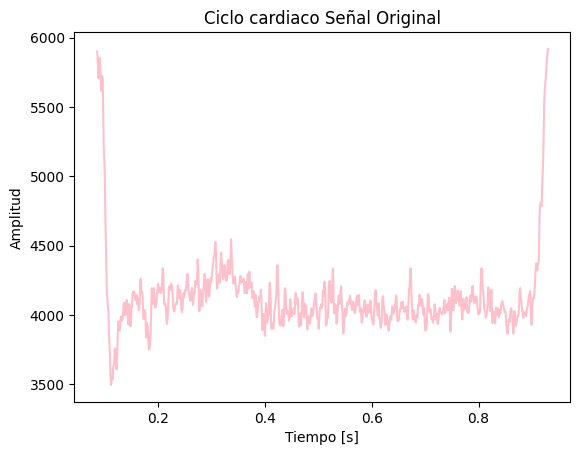

In [70]:
t_ciclo = t[peaks[0]:peaks[1]]
ciclo_cruda = ecg_cruda[peaks[0]:peaks[1]]
plt.plot(t_ciclo, ciclo_cruda, color = 'pink')
plt.title('Ciclo cardiaco Señal Original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

Estadísticas:

In [71]:
# Calcular promedio
promedio_crudo = np.mean(ecg_cruda)
print("El promedio de la señal original es: ", promedio_crudo)

# Calcular RMS
RMS_cruda = calcular_rms(ecg_cruda)
print("El RMS de la señal original es: ", RMS_cruda)

# Calcular la Varianza
varianza_cruda = np.var(ecg_cruda)
print("La varianza de la señal original es: ", varianza_cruda)

# Calcular Desviación estándar
desviacion_estandar_cruda = np.std(ecg_cruda)
print("La desviación estándar de la señal original es: ", desviacion_estandar_cruda)



El promedio de la señal original es:  4381.171892023087
El RMS de la señal original es:  4392.9682937490725
La varianza de la señal original es:  103503.2824314821
La desviación estándar de la señal original es:  321.7192602743611


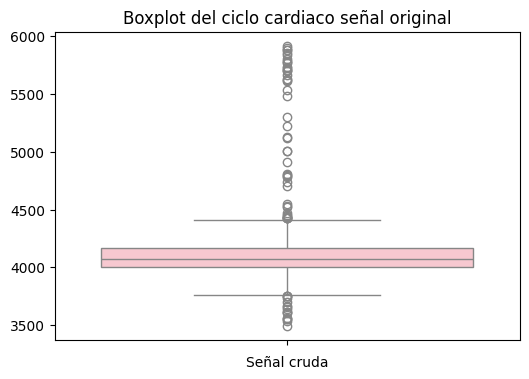

In [72]:
# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(ciclo_cruda, color='pink')
plt.title('Boxplot del ciclo cardiaco señal original')
plt.xlabel('Señal cruda')
plt.show()

**Analisis de los resultados:**

* La mayor parte de los valores de amplitud están agrupados alrededor del promedio 4381. Esto sugiere que hay un desplazamiento de base o offset en la señal, ya que no está centrada en cero.
* La magnitud promedio de la señal es cercana a 4393, lo que indica que los valores de la señal se mantienen relativamente constantes en torno al promedio.
* La varianza es de 103503.28, lo que significa que hay una gran dispersión de valores en la señal ECG, pudiendo ser por los picos altos que representan los latidos y las areas mas bajas entre cada latido. Además, La varianza también puede estar influenciada por ruido o artefactos en la señal, especialmente si hay muchos valores atípicos o fluctuaciones extremas.
* La desviación estándar de 321.72 muestra que hay muchas fluctuaciones alrededor del promedio, lo que refleja la variabilidad de los picos y las caídas en la señal ECG.

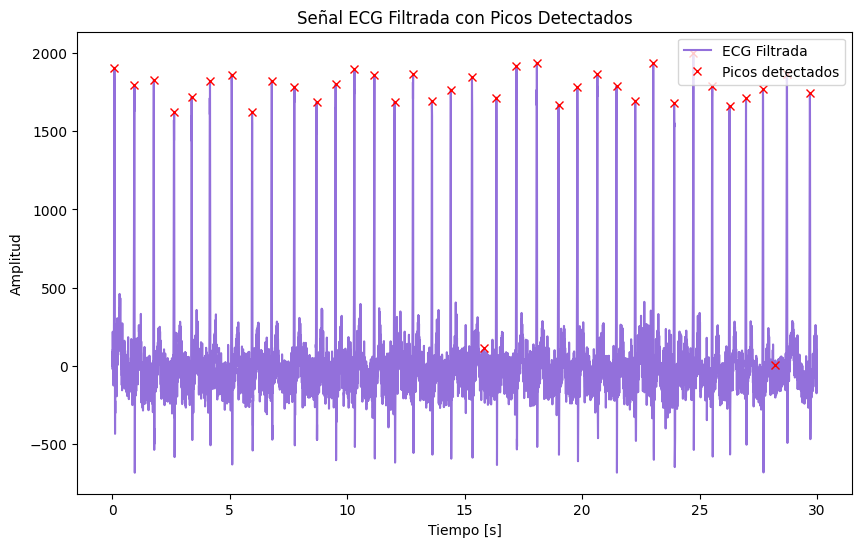

In [73]:
peaks, _ = find_peaks(ecg_filtrada, distance=Fs/2, height=0)  # Ajustar los parámetros si es necesario
plt.figure(figsize=(10, 6))
plt.plot(t, ecg_filtrada, label='ECG Filtrada', color='mediumpurple')
plt.plot(t[peaks], ecg_filtrada[peaks], 'rx', label='Picos detectados')
plt.title('Señal ECG Filtrada con Picos Detectados')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

Text(0, 0.5, 'Amplitud')

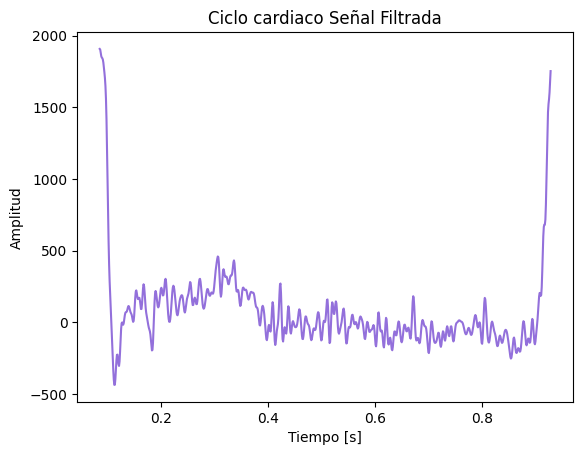

In [74]:
t_ciclo = t[peaks[0]:peaks[1]]
ciclo_filtrada = ecg_filtrada[peaks[0]:peaks[1]]
plt.plot(t_ciclo, ciclo_filtrada, color = 'mediumpurple')
plt.title('Ciclo cardiaco Señal Filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

In [75]:
# Calcular promedio
promedio_filtrado = np.mean(ecg_filtrada)
print("El promedio de la señal filtrada es: ", promedio_filtrado)

# Calcular RMS
RMS_filtrada = calcular_rms(ecg_filtrada)
print("El RMS de la señal filtrada es: ", RMS_filtrada)

# Calcular la Varianza
varianza_filtrada = np.var(ecg_filtrada)
print("La varianza de la señal filtrada es: ", varianza_filtrada)

# Calcular Desviación estándar
desviacion_estandar_filtrada = np.std(ecg_filtrada)
print("La desviación estándar de la señal filtrada es: ", desviacion_estandar_filtrada)


El promedio de la señal filtrada es:  3.1776396646094827
El RMS de la señal filtrada es:  286.30557115249496
La varianza de la señal filtrada es:  81960.78267911829
La desviación estándar de la señal filtrada es:  286.2879366636294


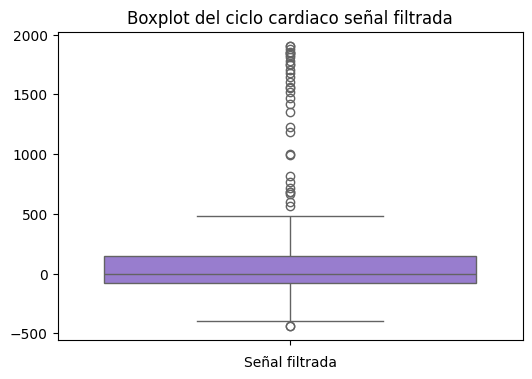

In [76]:
# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(ciclo_filtrada, color='mediumpurple')
plt.title('Boxplot del ciclo cardiaco señal filtrada')
plt.xlabel('Señal filtrada')
plt.show()

**Análisis de los resultados:**

* El promedio ahora es 3.18, lo que muestra que el filtrado ha corregido ese desplazamiento y ha centrado la señal en torno a cero.

* El RMS ha disminuido significativamente a 286.31, lo que indica que la señal es ahora más suave, con menos energía no deseada.

* La varianza ha disminuido a 81960.78, lo que muestra que la señal tiene menos fluctuaciones extremas, aunque los picos cardiacos aún generan dispersión.

*  La desviación estándar ha bajado a 286.29, lo que muestra una reducción en la variabilidad de la señal, aunque aún persisten algunas fluctuaciones, debido a los picos de los latidos.

Extracción de 15 ciclos para la señal filtrada:

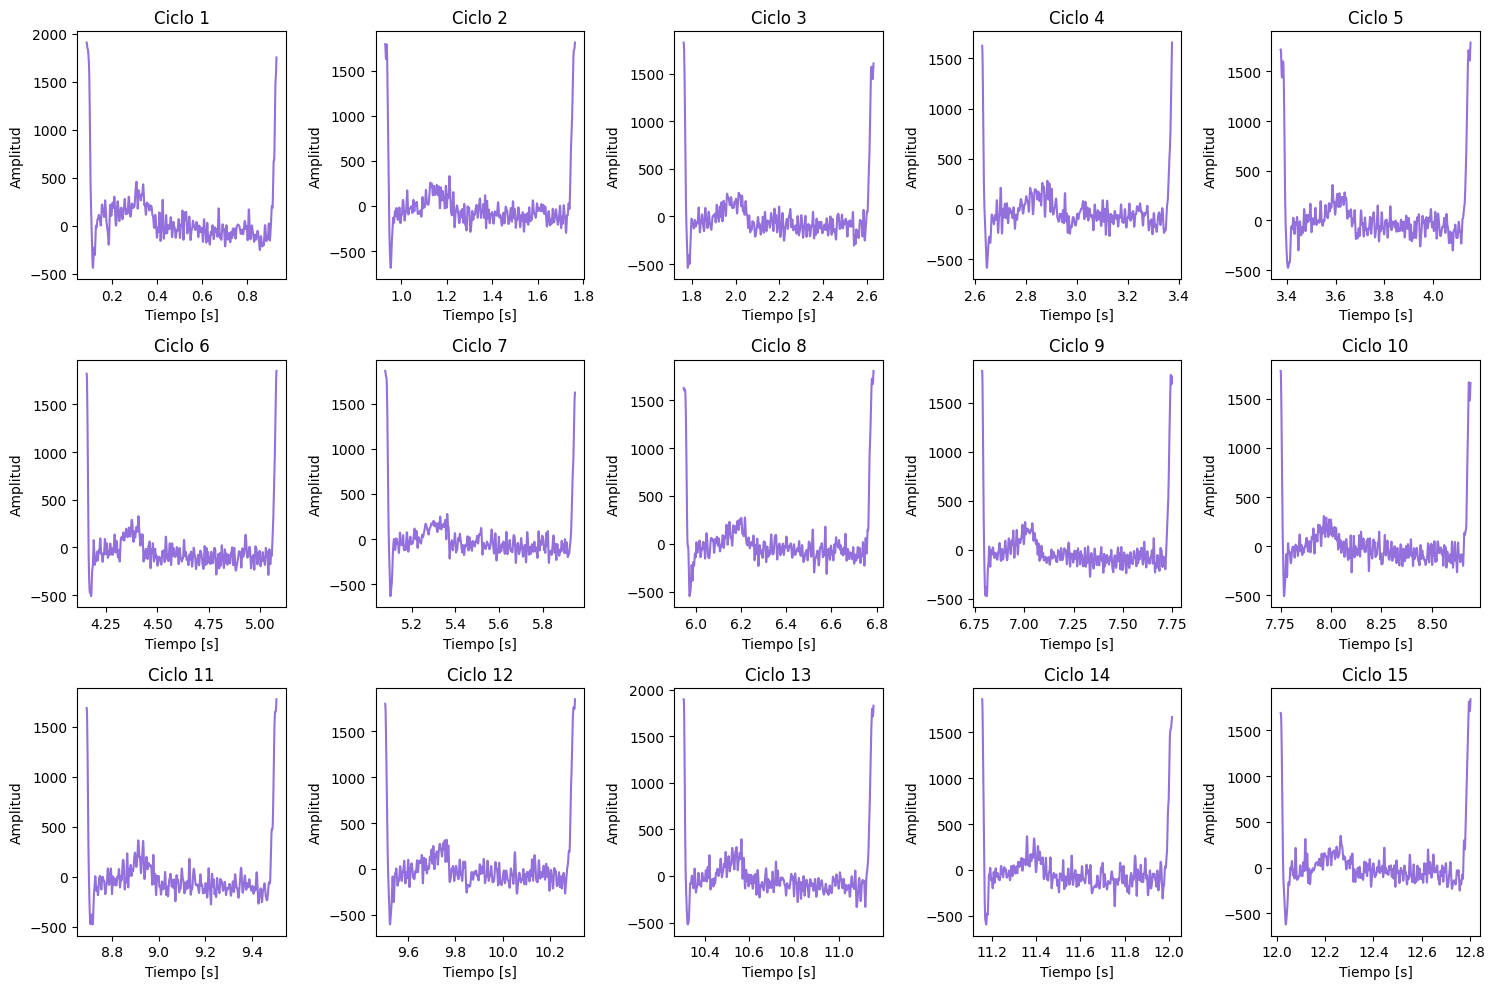

Ciclo 1: Promedio = 74.0100, Varianza = 96684.3149
Ciclo 2: Promedio = -1.4626, Varianza = 104790.4655
Ciclo 3: Promedio = -10.4330, Varianza = 82451.2511
Ciclo 4: Promedio = -20.9752, Varianza = 46839.0197
Ciclo 5: Promedio = 40.8711, Varianza = 114850.0201
Ciclo 6: Promedio = -27.9437, Varianza = 58147.5895
Ciclo 7: Promedio = 0.4308, Varianza = 77707.2812
Ciclo 8: Promedio = 21.4079, Varianza = 100268.1815
Ciclo 9: Promedio = -10.1753, Varianza = 71784.9558
Ciclo 10: Promedio = 8.8121, Varianza = 68481.0598
Ciclo 11: Promedio = -8.9062, Varianza = 76088.3849
Ciclo 12: Promedio = 13.2133, Varianza = 93862.6959
Ciclo 13: Promedio = -4.2033, Varianza = 87951.5045
Ciclo 14: Promedio = -14.9697, Varianza = 77022.1329
Ciclo 15: Promedio = 27.1083, Varianza = 89636.9356


In [77]:
# Extracción de 15 ciclos
ciclos = []
promedios = []
varianzas = []

fig, axs = plt.subplots(3, 5, figsize=(15, 10))  # 3 filas y 5 columnas

for i in range(15):
    ciclo_actual = ecg_filtrada[peaks[i]:peaks[i+1]]
    ciclos.append(ciclo_actual)
    promedio_ciclo = np.mean(ciclo_actual)
    promedios.append(promedio_ciclo)
    varianza_ciclo = np.var(ciclo_actual)
    varianzas.append(varianza_ciclo)

    t_ciclo = t[peaks[i]:peaks[i+1]]

    # Definir la posición en el subplot
    row = i // 5
    col = i % 5

    # Graficar el ciclo en la posición correspondiente
    axs[row, col].plot(t_ciclo, ciclo_actual, color='mediumpurple')
    axs[row, col].set_title(f'Ciclo {i+1}')
    axs[row, col].set_xlabel('Tiempo [s]')
    axs[row, col].set_ylabel('Amplitud')

# Ajustar la distribución del gráfico
plt.tight_layout()
plt.show()

# Mostrar los promedios y varianzas de cada ciclo
for i in range(15):
    print(f"Ciclo {i+1}: Promedio = {promedios[i]:.4f}, Varianza = {varianzas[i]:.4f}")


**Análisis grafico y estadistico**

**Análisis grafico:**

  * Los 15 ciclos gráficos muestran una estructura muy similar, sin embargo, las fluctuaciones entre los picos varían en amplitud y forma en cada ciclo.
  * Algunos ciclos tienen mayores oscilaciones, mientras que otros son más estables (con amplitudes más bajas).
  
  Estas diferencias visuales entre los ciclos sugiere que la señal no es constante.

**Análisis estadistico**

* Los promedios de los ciclos varían considerablemente. Van desde valores negativos hasta valores positivo. Estos cambios en el promedio indica que la señal no se mantiene estable a lo largo de todos los ciclos.

* La varianza, que mide la dispersión de los valores de cada ciclo, también muestra una alta variabilidad. Algunas varianzas son mucho mayores que otras, por ejemplo, el ciclo 2 tiene una varianza de 104790.47, mientras que el ciclo 6 tiene una varianza mucho menor de 58147.59. Esto sugiere que algunos ciclos tienen fluctuaciones mucho más extremas que otros, lo que contribuye a que la señal sea menos estable.

No se puede considerar que la señal es estacionaria debido a la variabilidad en las estadísticas de cada ciclo y la diferencia en el comportamiento gráfico entre ciclos. Tanto los gráficos como los valores del promedio y la varianza demuestran que la señal cambia con el tiempo, lo que es indicativo de una señal no estacionaria.

## Comparación entre el ciclo 2 y ciclo 5


**Normalidad:**

Prueba de Kolmogorov-Smirnov

**Hipótesis:**

p > alpha

*   H0: Los datos parecen normales (No se puede rechazar H0)
*   H1: Los datos no parecen normales (Se rechaza H0)



In [78]:
ciclo_dos = ciclos[1]
ciclo_cinco = ciclos[4]

ks_stats2, p_value2 = kstest(ciclo_dos, 'norm')
print('stat=%.3f, p=%.3f' % (ks_stats2, p_value2))

if p_value2 > 0.05:
  print('Los datos parecen normales (No se puede rechazar H0)')
else:
  print('Los datos no parecen normales (Se rechaza H0)')


stat=0.708, p=0.000
Los datos no parecen normales (Se rechaza H0)


In [79]:
ks_stats5, p_value5 = kstest(ciclo_cinco, 'norm')
print('stat=%.3f, p=%.3f' % (ks_stats5, p_value5))

if p_value5 > 0.05:
  print('Los datos parecen normales (No se puede rechazar H0)')
else:
  print('Los datos no parecen normales (Se rechaza H0)')

stat=0.587, p=0.000
Los datos no parecen normales (Se rechaza H0)


Tanto para el ciclo 2 como para el ciclo 5, se rechaza la hipótesis nula H0, lo que significa que los datos no siguen una distribución normal. Esto se deduce del valor p = 0.000, que es menor al nivel de significancia alpha = 0.05.
Esto implica que, estadísticamente, los datos de ambos ciclos no pueden ser considerados como normalmente distribuidos, lo que afecta la validez de pruebas paramétricas tradicionales como la t de Student.

**Homocedasticidad:**

Prueba de Levene

**Hipótesis:**

*   H0: Los grupos tienen varianzas iguales
*   H1: Los grupos tienen varianzas diferentes



In [80]:
stat_levene, p_levene = levene(ciclo_dos, ciclo_cinco)
print('stat=%.3f, p=%.3f' % (stat_levene, p_levene))

if p_levene > 0.05:
  print('Los grupos tienen varianzas iguales (No se puede rechazar H0)')
else:
  print('Los grupos tienen varianzas diferentes (Se rechaza H0)')

stat=0.607, p=0.436
Los grupos tienen varianzas iguales (No se puede rechazar H0)


La prueba de Levene para la homocedasticidad muestra un valor p = 0.436, lo que significa que no se puede rechazar la hipótesis nula H0 de que los dos ciclos tienen varianzas iguales.
Esto indica que, aunque los datos no son normales, los ciclos 2 y 5 tienen varianzas similares, lo que es un requisito para aplicar algunas pruebas estadísticas, como la prueba t aunque en este caso, optamos por una prueba no paramétrica.

**Independencia**

Se asume que los grupos son independientes

**U Mann-Whitney-Wilcoxon**

* HO: No hay diferencia (en términos de tendencia central) entre los dos grupos de la población.
* H1: Existe una diferencia (con respecto a la tendencia central) entre los dos grupos de la población.

Las condiciones del u-test son:

* Los datos tienen que ser independientes.

* Los datos tienen que ser ordinales.

* No es necesario asumir que las muestras se distribuyen de forma normal.

* Igualdad de varianza entre grupos (homocedasticidad).

In [81]:
stat_mann, p_mann = mannwhitneyu(ciclo_dos, ciclo_cinco)
print('stat=%.3f, p=%.0f' % (stat_mann, p_mann))

if p_mann > 0.05:
  print('No se puede rechazar H0, no hay diferencias significativas entre los ciclos.')
else:
  print('Se rechaza H0, hay diferencias significativas entre los ciclos.')

stat=285265.000, p=0
Se rechaza H0, hay diferencias significativas entre los ciclos.


Se rechaza la hipótesis nula, lo que indica que hay diferencias significativas entre los dos grupos. Esto significa que los datos de los grupos probablemente provienen de distribuciones diferentes.

La prueba de Mann-Whitney muestra un valor p = 0, lo que significa que se rechaza la hipótesis nula. Esto indica que hay diferencias significativas entre los ciclos 2 y 5.
Esto sugiere que las distribuciones de los valores de los dos ciclos son diferentes, lo que implica que estos dos ciclos tienen características distintas.

**Análisis ciclo 2 y 5**



## Comparación entre el ciclo 13 y ciclo 15

**Normalidad:**

Prueba de Kolmogorov-Smirnov

**Hipótesis:**

p > alpha

*   H0: Los datos parecen normales (No se puede rechazar H0)
*   H1: Los datos no parecen normales (Se rechaza H0)


In [82]:
ciclo_13 = ciclos[12]
ciclo_15 = ciclos[14]

ks_stats13, p_value13 = kstest(ciclo_13, 'norm')
print('stat=%.3f, p=%.3f' % (ks_stats13, p_value13))

if p_value13 > 0.05:
  print('Los datos parecen normales (No se puede rechazar H0)')
else:
  print('Los datos no parecen normales (Se rechaza H0)')

stat=0.704, p=0.000
Los datos no parecen normales (Se rechaza H0)


In [83]:
ks_stats15, p_value15 = kstest(ciclo_15, 'norm')
print('stat=%.3f, p=%.3f' % (ks_stats15, p_value15))

if p_value15 > 0.05:
  print('Los datos parecen normales (No se puede rechazar H0)')
else:
  print('Los datos no parecen normales (Se rechaza H0)')

stat=0.587, p=0.000
Los datos no parecen normales (Se rechaza H0)


Para ambos ciclos, 13 y 15, se rechaza la hipótesis nula, lo que indica que los datos no siguen una distribución normal. Este resultado se puede observar debido a los valores de p = 0.000, que son menores al nivel de significancia 𝛼 = 0.05.
Esto implica que las señales de ambos ciclos tienen una distribución que no es normal, lo que afecta la validez de pruebas paramétricas tradicionales como la t de Student.

**Homocedasticidad:**

Prueba de Levene

**Hipótesis:**

*   H0: Los grupos tienen varianzas iguales
*   H1: Los grupos tienen varianzas diferentes

In [84]:
stat_levene, p_levene = levene(ciclo_13, ciclo_15)
print('stat=%.3f, p=%.3f' % (stat_levene, p_levene))

if p_levene > 0.05:
  print('Los grupos tienen varianzas iguales (No se puede rechazar H0)')
else:
  print('Los grupos tienen varianzas diferentes (Se rechaza H0)')

stat=0.198, p=0.656
Los grupos tienen varianzas iguales (No se puede rechazar H0)


La prueba de Levene muestra un valor p = 0.656, lo que significa que no se puede rechazar la hipótesis nula ya que las varianzas de los ciclos 13 y 15 son iguales. Esto indica que, a pesar de que los datos no son normales, las variaciones de amplitud en ambos ciclos tienen una dispersión similar, lo cual es un aspecto importante para validar algunas pruebas estadísticas no paramétricas.

**Independencia**

Se asume que los grupos son independientes

**U Mann-Whitney-Wilcoxon**

* HO: No hay diferencia (en términos de tendencia central) entre los dos grupos de la población.
* H1: Existe una diferencia (con respecto a la tendencia central) entre los dos grupos de la población.

Las condiciones del u-test son:

* Los datos tienen que ser independientes.

* Los datos tienen que ser ordinales.

* No es necesario asumir que las muestras se distribuyen de forma normal.

* Igualdad de varianza entre grupos (homocedasticidad).


In [85]:
stat_mann, p_mann = mannwhitneyu(ciclo_13, ciclo_15)
print('stat=%.3f, p=%.0f' % (stat_mann, p_mann))

if p_mann > 0.05:
  print('No se puede rechazar H0, no hay diferencias significativas entre los ciclos.')
else:
  print('Se rechaza H0, hay diferencias significativas entre los ciclos.')

stat=293838.000, p=0
Se rechaza H0, hay diferencias significativas entre los ciclos.


El valor p = 0 para la prueba de Mann-Whitney indica que se rechaza la hipótesis nula, lo que significa que existen diferencias significativas entre los ciclos 13 y 15.
Esto sugiere que los dos ciclos tienen distribuciones diferentes en cuanto a sus valores de amplitud, lo que implica que sus comportamientos a lo largo del tiempo son distintos.

**Estacionariedad**

Prueba de Dickey-Fuller

* HO: La serie temporal no es estacionaria, es decir, tiene una estructura que depende del tiempo y no presenta una varianza constante a lo largo del tiempo.

* H1: La serie temporal es estacionaria.

Estadístico ADF: Es el valor que indica qué tan lejos está la serie de ser estacionaria (valores más negativos indican estacionariedad).

Valores críticos: Estos son los valores del estadístico ADF que debes comparar para niveles de significancia del 1%, 5%, y 10%.

In [86]:
result = adfuller(ecg_filtrada)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] <= 0.05:
  print("La serie temporal es estacionaria.")
else:
  print("La serie temporal no es estacionaria.")

ADF Statistic: -0.654659
p-value: 0.858147
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
La serie temporal no es estacionaria.


La señal no es estacionaria, es probable que esto afecte las comparaciones entre los ciclos. Es decir, la no estacionariedad podría ser la razón de las diferencias entre ciclos, ya que las propiedades de la señal cambian a lo largo del tiempo, lo cual es consistente con el análisis anterior donde se observaron fluctuaciones en la señal a lo largo de los ciclos.